## 7. WAV 파일 데시벨 분포 검토

### 1) RMS(교류 신호 크기) 측정 방식


📈 클래스별 데시벨 통계 (dB):
                                             count       mean       std  \
class_label                                                               
1.Car/1.horn_of_car                         3588.0 -22.984406  9.046573   
1.Car/2.siren_of_car                        2239.0 -23.957921  8.225161   
1.Car/3.driving_sound_of_car                1909.0 -20.443864  4.869635   
2.Motorcycle/4.horn_of_motorcycle           5079.0 -24.134283  6.979487   
2.Motorcycle/5.driving_sound_of_motorcycle  5233.0 -21.638685  5.844568   

                                                  min        25%        50%  \
class_label                                                                   
1.Car/1.horn_of_car                        -48.958297 -28.884965 -19.847460   
1.Car/2.siren_of_car                       -54.894738 -29.910265 -23.108744   
1.Car/3.driving_sound_of_car               -40.334081 -23.429598 -19.182983   
2.Motorcycle/4.horn_of_motorcycle          -46.574493 -29.

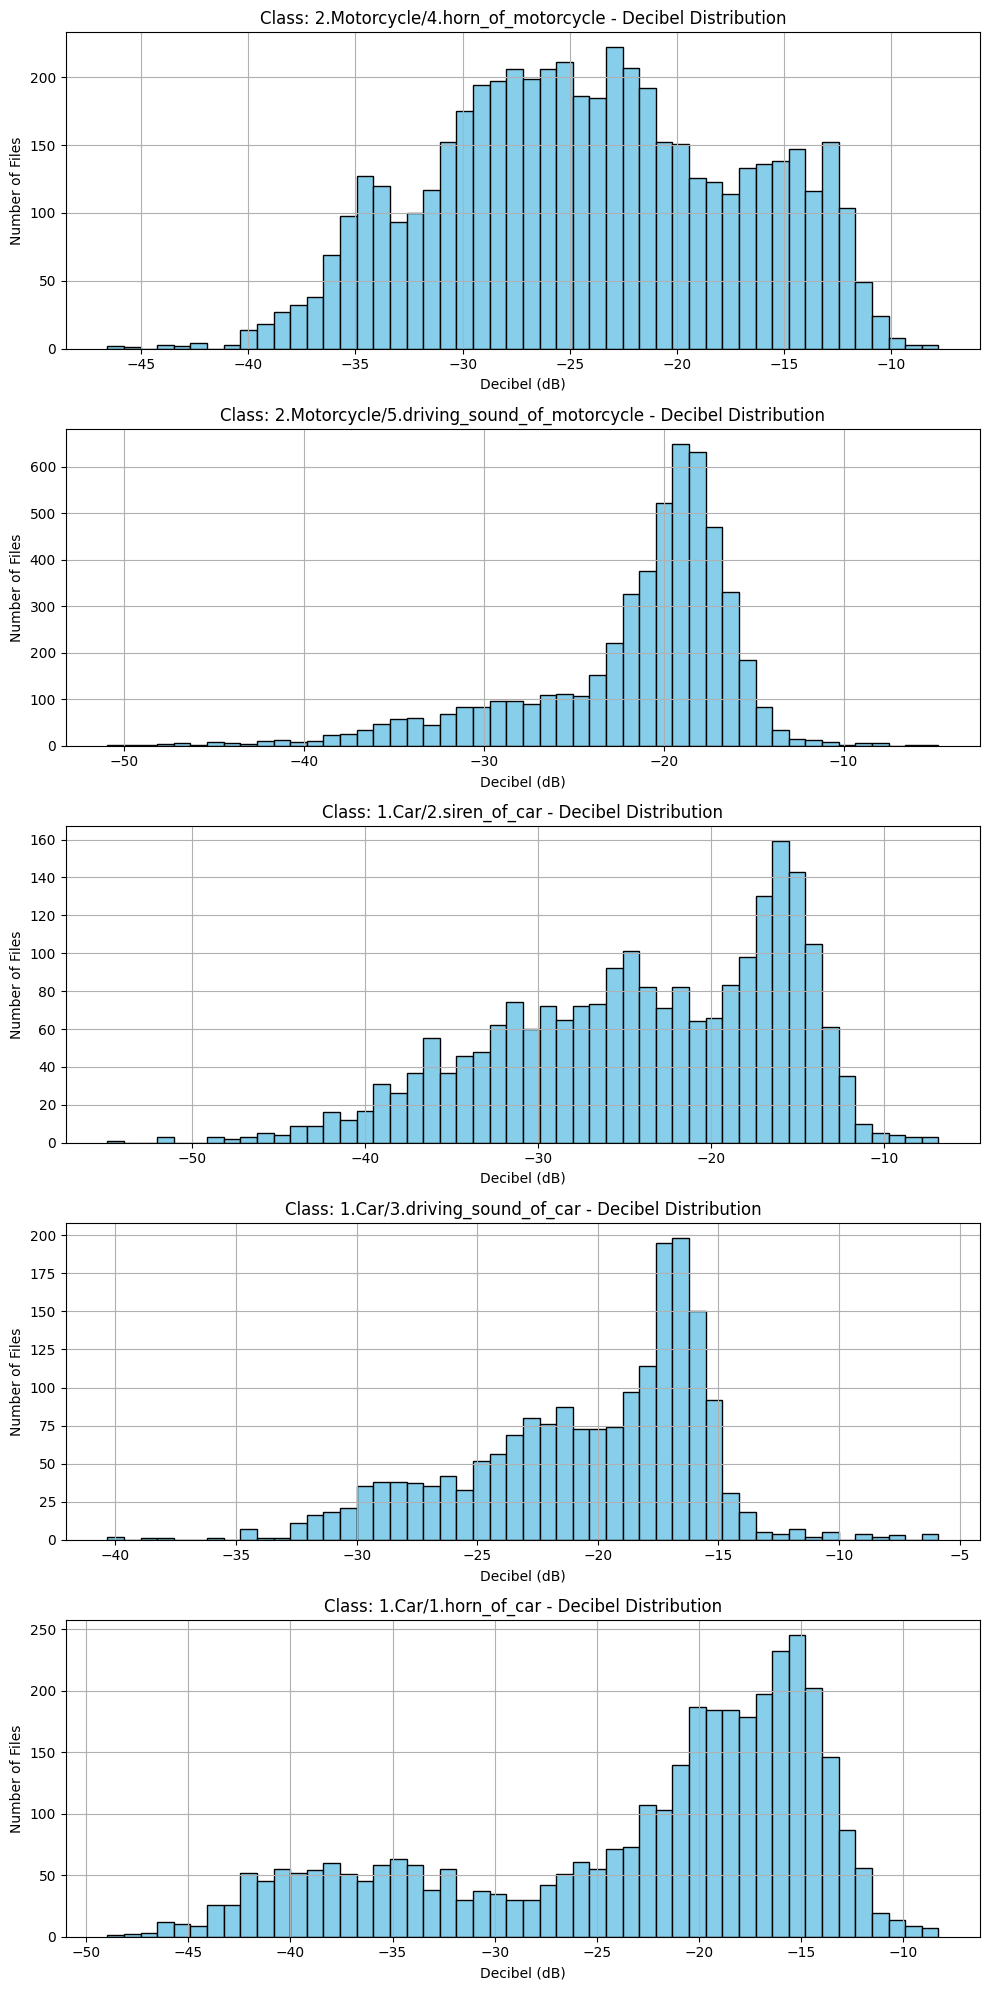

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 분석할 WAV 파일이 위치한 상위 디렉토리
data_dir = "/home/ubuntu/data"

# 파일 정보를 저장할 리스트
file_info_list = []

# 검사할 파일 확장자
audio_extensions = [".wav"]

# WAV 파일 검사
for root, _, files in os.walk(data_dir):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(root, file)
            try:
                # librosa로 파일 로드하여 오디오 데이터 및 샘플링 레이트 획득
                y, sr = librosa.load(file_path, sr=None, mono=True)
                
                # 오디오 신호의 RMS 값 계산
                rms = np.sqrt(np.mean(y ** 2))
                
                # RMS 값을 데시벨로 변환 (참조값을 1로 설정)
                db = 20 * np.log10(rms + 1e-6)  # 1e-6은 로그의 -무한대를 방지하기 위해 더함

                # 클래스 정보 추출 (예시로, 상위 2개의 폴더 이름을 사용)
                path_parts = os.path.normpath(file_path).split(os.sep)
                class_label = os.path.join(path_parts[-3], path_parts[-2])  # 예: '2.Motorcycle/4.horn_of_motorcycle'

                # 파일 정보 저장
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "db": db,
                    "class_label": class_label
                })

            except Exception as e:
                # 파일 로드 중 오류 발생 시 데시벨 값을 None으로 설정
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "db": None,
                    "class_label": None,
                    "error_msg": str(e)
                })

# 데이터프레임으로 변환
df = pd.DataFrame(file_info_list)

# 오류가 없는 파일만 선택
df_valid = df[df["db"].notnull()]

# 클래스별 데시벨 통계 계산
class_db_stats = df_valid.groupby("class_label")["db"].describe()
print("\n📈 클래스별 데시벨 통계 (dB):")
print(class_db_stats)

# 클래스별 데시벨 분포 시각화
unique_classes = df_valid["class_label"].unique()
num_classes = len(unique_classes)

# 그래프 크기 설정
fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 4*num_classes))

if num_classes == 1:
    axes = [axes]  # 클래스가 하나인 경우에도 리스트로 만들기

for i, class_label in enumerate(unique_classes):
    class_data = df_valid[df_valid["class_label"] == class_label]
    axes[i].hist(class_data["db"], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Class: {class_label} - Decibel Distribution')
    axes[i].set_xlabel('Decibel (dB)')
    axes[i].set_ylabel('Number of Files')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### 2) db SPL(음압 레벨) 측정 방식


📈 클래스별 dBSPL 통계 (dB):
                                             count        mean       std  \
class_label                                                                
1.Car/1.horn_of_car                         3588.0  116.015594  9.046573   
1.Car/2.siren_of_car                        2239.0  115.042079  8.225161   
1.Car/3.driving_sound_of_car                1909.0  118.556136  4.869635   
2.Motorcycle/4.horn_of_motorcycle           5079.0  114.865717  6.979487   
2.Motorcycle/5.driving_sound_of_motorcycle  5233.0  117.361315  5.844568   

                                                  min         25%         50%  \
class_label                                                                     
1.Car/1.horn_of_car                         90.041703  110.115035  119.152540   
1.Car/2.siren_of_car                        84.105262  109.089735  115.891256   
1.Car/3.driving_sound_of_car                98.665919  115.570402  119.817017   
2.Motorcycle/4.horn_of_motorcycle      

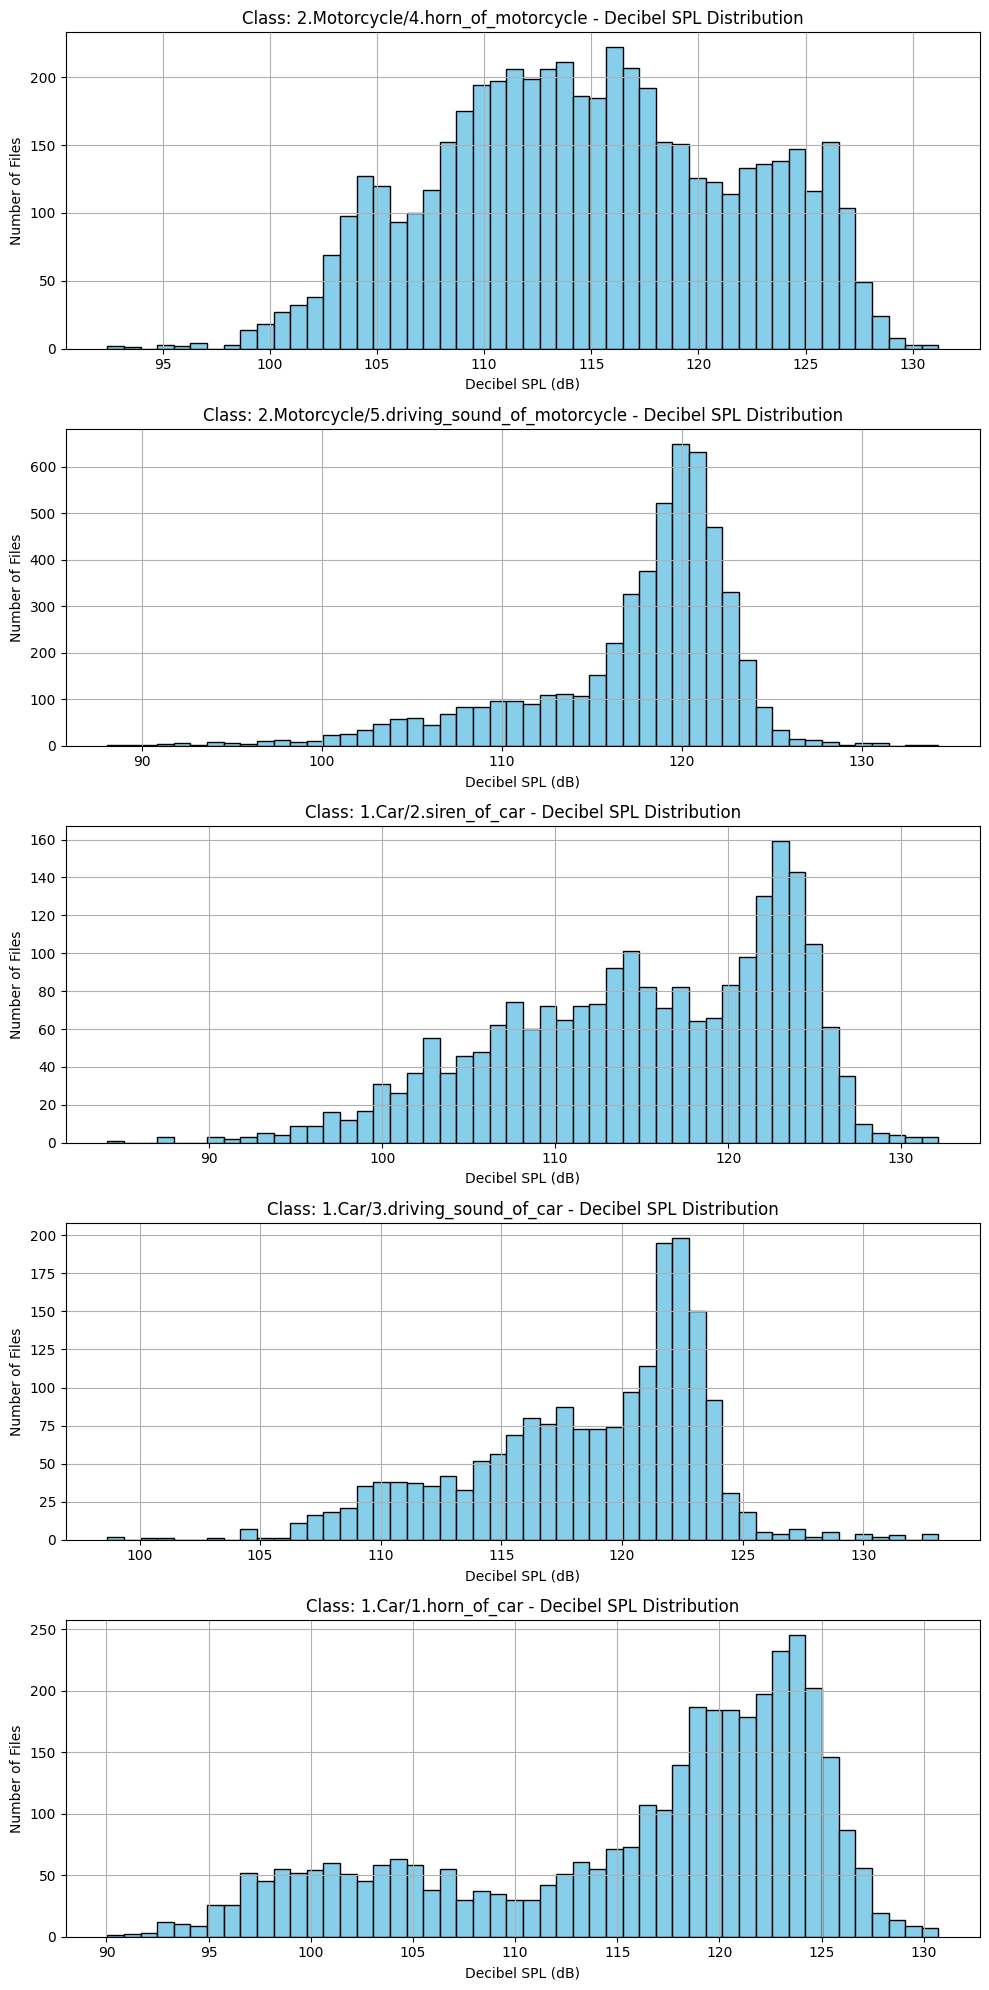


🚨 소리가 너무 작은 파일 목록 (최대 10개):


In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 분석할 WAV 파일이 위치한 상위 디렉토리
data_dir = "/home/ubuntu/data"

# 파일 정보를 저장할 리스트
file_info_list = []

# 검사할 파일 확장자
audio_extensions = [".wav"]

# 모든 장비의 보정값 설정 (예시로, -45 dB 감도 + 94 dBSPL 기준음압 수준)
correction_value = 94 - (-45)  # 보정값 설정

# 소리가 너무 작은 파일을 저장할 리스트
low_volume_files = []

# WAV 파일 검사
for root, _, files in os.walk(data_dir):
    for file in files:
        if any(file.endswith(ext) for ext in audio_extensions):
            file_path = os.path.join(root, file)
            try:
                # librosa로 파일 로드하여 오디오 데이터 및 샘플링 레이트 획득
                y, sr = librosa.load(file_path, sr=None, mono=True)
                
                # 오디오 신호의 RMS 값 계산
                rms = np.sqrt(np.mean(y ** 2))
                
                # RMS 값을 dBSPL로 변환
                dbspl = 20 * np.log10(rms + 1e-6) + correction_value  # 1e-6은 로그의 -무한대를 방지하기 위해 더함

                # 클래스 정보 추출 (예시로, 상위 2개의 폴더 이름을 사용)
                path_parts = os.path.normpath(file_path).split(os.sep)
                class_label = os.path.join(path_parts[-3], path_parts[-2])  # 예: '2.Motorcycle/4.horn_of_motorcycle'

                # 소리가 너무 작은 경우 체크 (예: 30 dBSPL 이하)
                if dbspl < 30:
                    low_volume_files.append((file_path, dbspl))

                # 파일 정보 저장
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "dbspl": dbspl,
                    "class_label": class_label
                })

            except Exception as e:
                # 파일 로드 중 오류 발생 시 데시벨 값을 None으로 설정
                file_info_list.append({
                    "file_path": file_path,
                    "file_name": file,
                    "dbspl": None,
                    "class_label": None,
                    "error_msg": str(e)
                })

# 데이터프레임으로 변환
df = pd.DataFrame(file_info_list)

# 오류가 없는 파일만 선택
df_valid = df[df["dbspl"].notnull()]

# 클래스별 데시벨 통계 계산
class_dbspl_stats = df_valid.groupby("class_label")["dbspl"].describe()
print("\n📈 클래스별 dBSPL 통계 (dB):")
print(class_dbspl_stats)

# 클래스별 데시벨 분포 시각화
unique_classes = df_valid["class_label"].unique()
num_classes = len(unique_classes)

if num_classes > 0:  # 클래스가 있는 경우에만 그래프 생성
    # 그래프 크기 설정
    fig, axes = plt.subplots(nrows=num_classes, ncols=1, figsize=(10, 4*num_classes))

    if num_classes == 1:
        axes = [axes]  # 클래스가 하나인 경우에도 리스트로 만들기

    for i, class_label in enumerate(unique_classes):
        class_data = df_valid[df_valid["class_label"] == class_label]
        axes[i].hist(class_data["dbspl"], bins=50, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Class: {class_label} - Decibel SPL Distribution')
        axes[i].set_xlabel('Decibel SPL (dB)')
        axes[i].set_ylabel('Number of Files')
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 클래스가 없습니다. 그래프를 생성할 수 없습니다.")

# 소리가 너무 작은 파일 목록 출력 (최대 10개)
print("\n🚨 소리가 너무 작은 파일 목록 (최대 10개):")
for file_path, dbspl in low_volume_files[:10]:
    print(f"파일: {file_path}, dBSPL: {dbspl:.2f}")

### (참고) dB SPL과 RMS의 차이점

- dB SPL(데시벨 음압 레벨)과 RMS(제곱 평균 제곱근)는 둘 다 소리의 크기를 나타내는 단위이지만, 그 의미와 사용 목적에 차이가 있습니다.

```
1. dB SPL (데시벨 음압 레벨)

- 정의: dB SPL은 소리의 압력, 즉 음압을 나타내는 단위입니다. 인간이 느낄 수 있는 가장 작은 소리 크기를 0 dB SPL로 기준으로 하여, 소리가 클수록 dB SPL 값이 커집니다.
- 특징:
  인간의 청각 특성을 고려하여, 주파수별로 다른 가중치를 적용한 dB(A), dB(B), dB(C) 등의 단위로 표현하기도 합니다.
  소음 측정, 음향 기기 성능 평가 등에 사용됩니다.
  
2. RMS (제곱 평균 제곱근)
- 정의: RMS는 교류 신호의 크기를 나타내는 단위입니다. 오디오 신호의 경우, RMS 값은 신호의 전력에 비례하며, 소리의 크기와 관련됩니다.
- 특징:
  시간에 따라 변하는 신호의 크기를 평균적으로 나타냅니다.
  오디오 신호 처리, 전력 계산 등에 사용됩니다.
```
3. 차이점
| 구분 | dB SPL | RMS |
|---|---|---|
| 의미 | 음압 레벨 | 교류 신호 크기 |
| 사용 목적 | 소음 측정, 음향 기기 평가 | 오디오 신호 처리, 전력 계산 |
| 특징 | 인간 청각 특성 고려 | 시간에 따른 신호 평균값 |

```
4. 결론
- dB SPL은 소리의 크기를 인간의 청각에 맞춰 나타내는 단위이고, RMS는 교류 신호의 크기를 평균적으로 나타내는 단위입니다.
-따라서 두 단위는 소리의 크기를 나타내는 데 관련이 있지만, 그 의미와 사용 목적에 차이가 있습니다.

5. 추가 정보
- dB SPL 값은 소음 측정기나 음향 분석기를 사용하여 측정할 수 있습니다.
- RMS 값은 오실로스코프나 전압계 등을 사용하여 측정할 수 있습니다.
```